In [2]:
import numpy as np
import matplotlib.pylab as plt
import random
import copy
import pandas
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import pickle
from tqdm import *

Load Data
======

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
X = []
Y = []

for b in range(1, 6):
    D = unpickle('./cifar-10-batches-py/data_batch_%s' % b)
    X.append( D[b'data'].reshape((-1, 3, 32, 32)).astype('uint8') )
    Y.append( np.array(D[b'labels']))
    names = [x.decode('utf-8') for x in D]

X = np.vstack(X)
Y = np.hstack(Y).astype('int')

D = unpickle('./cifar-10-batches-py/test_batch')
Xt = D[b'data'].reshape((-1, 3, 32, 32)).astype('uint8')
Yt = np.array(D[b'labels']).astype('int')
Lt = D[b'filenames']

DataLoader
===

Model
=====

In [21]:
class Net(nn.Module):  
    def __init__(self,batch_size = 10, drop_probability = 0.5):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.drop = nn.Dropout2d(drop_probability)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.drop = nn.Dropout2d(drop_probability)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(5 * 5 * 128, 5 * 5 * 64)
        self.fc2 = nn.Linear(5 * 5 * 64, 5 * 5 * 50)
        self.fc3 = nn.Linear(5 * 5 * 50, batch_size)
        
        self.train_epoch_loss_list = []
        self.test_epoch_loss_list = []

    def forward(self, x): 
        x = self.pool(F.relu(self.bn1(self.drop(self.conv1(x))))) 
        x = self.pool(F.relu(self.bn2(self.drop(self.conv2(x))))) 
        x = x.view(-1, 128 * 5 * 5)
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x   

Train Model
====

In [22]:
n_epoch = 40
batch_size = 2000
drop_probability = 0.3
lr = 0.001

In [23]:
net = Net(batch_size=batch_size, drop_probability=drop_probability).cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

net

Net (
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (drop): Dropout2d (p=0.3)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (fc1): Linear (3200 -> 1600)
  (fc2): Linear (1600 -> 1250)
  (fc3): Linear (1250 -> 2000)
)

In [29]:
Y.shape[0]

50000

In [35]:
%%time

train_epoch_loss_list = []
test_epoch_loss_list = []
for epoch in range(n_epoch):
    train_epoch_loss = 0
    test_epoch_loss = 0
    running_corrects = 0
    
    print ('\nEpoch %s/%s' %(epoch+1,n_epoch))
    Xperm = np.random.permutation(X.shape[0])
    net.train(True)
    for b in tqdm(range(X.shape[0]//batch_size)):
        batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
        
        x = Variable(torch.Tensor(X[batch_idxs].tolist())).cuda()
        y = Variable(torch.LongTensor(Y[batch_idxs].tolist())).cuda()
        
        y_hat = net(x)
        loss = criterion(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.data[0]
        
        _, preds = torch.max(y_hat.data, 1)
        running_corrects += torch.sum(preds == y.data)
    
    print ("Epoch acc: %s %s/%s" %(running_corrects/Y.shape[0],running_corrects,Y.shape[0]))
    ## learn test
    Xperm = np.random.permutation(Xt.shape[0])
    net.train(False)
    for b in range(Xt.shape[0]//batch_size):
        batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
        x = Variable(torch.Tensor(Xt[batch_idxs].tolist()),volatile = True).cuda()
        y = Variable(torch.LongTensor(Yt[batch_idxs]),volatile = True).cuda()

        y_hat = net(x)
        loss = criterion(y_hat, y)
        test_epoch_loss += loss.data[0]
    
    # save loss and lr for current epoch
    train_epoch_loss_list.append(train_epoch_loss)
    test_epoch_loss_list.append(test_epoch_loss)
    print ("Epoch loss: \ntrain: %s \ntest: %s\n" %(train_epoch_loss_list[-1], test_epoch_loss_list[-1]))
    
net.train_epoch_loss_list = train_epoch_loss_list
net.test_epoch_loss_list = test_epoch_loss_list

  0%|          | 0/25 [00:00<?, ?it/s]


Epoch 1/40


100%|██████████| 25/25 [00:32<00:00,  1.29s/it]


Epoch acc: 0.74768 37384/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 17.999417066574097 
test: 4.060343563556671


Epoch 2/40


100%|██████████| 25/25 [00:33<00:00,  1.32s/it]


Epoch acc: 0.75426 37713/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 17.519616067409515 
test: 3.810695469379425


Epoch 3/40


100%|██████████| 25/25 [00:34<00:00,  1.36s/it]


Epoch acc: 0.75644 37822/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 17.34060162305832 
test: 3.9484386444091797


Epoch 4/40


100%|██████████| 25/25 [00:33<00:00,  1.35s/it]


Epoch acc: 0.75694 37847/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 17.218117237091064 
test: 4.056737661361694


Epoch 5/40


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Epoch acc: 0.7665 38325/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 16.725447356700897 
test: 3.8627511262893677


Epoch 6/40


100%|██████████| 25/25 [00:33<00:00,  1.35s/it]


Epoch acc: 0.76658 38329/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 16.675677120685577 
test: 3.7818904519081116


Epoch 7/40


100%|██████████| 25/25 [00:32<00:00,  1.30s/it]


Epoch acc: 0.7682 38410/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 16.418337762355804 
test: 3.839872121810913


Epoch 8/40


100%|██████████| 25/25 [00:33<00:00,  1.35s/it]


Epoch acc: 0.77424 38712/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 15.991123795509338 
test: 3.7406097650527954


Epoch 9/40


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Epoch acc: 0.7762 38810/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 15.935643196105957 
test: 4.111168622970581


Epoch 10/40


100%|██████████| 25/25 [00:34<00:00,  1.36s/it]


Epoch acc: 0.7807 39035/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 15.493129968643188 
test: 4.10466593503952


Epoch 11/40


100%|██████████| 25/25 [00:33<00:00,  1.33s/it]


Epoch acc: 0.7863 39315/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 15.235549688339233 
test: 3.678722620010376


Epoch 12/40


100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


Epoch acc: 0.7853 39265/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 15.229189932346344 
test: 3.896969199180603


Epoch 13/40


100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


Epoch acc: 0.79088 39544/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 14.975942552089691 
test: 3.9626355171203613


Epoch 14/40


100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


Epoch acc: 0.79324 39662/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 14.603749454021454 
test: 3.756901204586029


Epoch 15/40


100%|██████████| 25/25 [00:33<00:00,  1.34s/it]


Epoch acc: 0.79306 39653/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 14.579311847686768 
test: 3.81454598903656


Epoch 16/40


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Epoch acc: 0.80118 40059/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 14.183095633983612 
test: 3.904616057872772


Epoch 17/40


100%|██████████| 25/25 [00:33<00:00,  1.35s/it]


Epoch acc: 0.80092 40046/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 14.127773523330688 
test: 3.996553897857666


Epoch 18/40


100%|██████████| 25/25 [00:34<00:00,  1.36s/it]


Epoch acc: 0.80232 40116/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 14.021923243999481 
test: 3.7674805521965027


Epoch 19/40


100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


Epoch acc: 0.80568 40284/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 13.811731934547424 
test: 3.821771204471588


Epoch 20/40


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Epoch acc: 0.80446 40223/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 13.663533926010132 
test: 3.8615314960479736


Epoch 21/40


100%|██████████| 25/25 [00:43<00:00,  1.74s/it]


Epoch acc: 0.8132 40660/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 13.280765742063522 
test: 3.8335129618644714


Epoch 22/40


100%|██████████| 25/25 [00:41<00:00,  1.65s/it]


Epoch acc: 0.8151 40755/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 13.015574127435684 
test: 3.9688112139701843


Epoch 23/40


100%|██████████| 25/25 [00:41<00:00,  1.65s/it]


Epoch acc: 0.8176 40880/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 12.902352094650269 
test: 4.019675970077515


Epoch 24/40


100%|██████████| 25/25 [00:36<00:00,  1.48s/it]


Epoch acc: 0.82266 41133/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 12.585364699363708 
test: 3.8017075061798096


Epoch 25/40


100%|██████████| 25/25 [00:33<00:00,  1.34s/it]


Epoch acc: 0.82108 41054/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 12.627511858940125 
test: 3.996423602104187


Epoch 26/40


100%|██████████| 25/25 [00:33<00:00,  1.35s/it]


Epoch acc: 0.82316 41158/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 12.556300640106201 
test: 4.187171936035156


Epoch 27/40


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Epoch acc: 0.8252 41260/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 12.336574882268906 
test: 3.757472515106201


Epoch 28/40


100%|██████████| 25/25 [00:34<00:00,  1.36s/it]


Epoch acc: 0.82886 41443/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 12.150904566049576 
test: 4.043286561965942


Epoch 29/40


100%|██████████| 25/25 [00:33<00:00,  1.34s/it]


Epoch acc: 0.83388 41694/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 11.7386953830719 
test: 3.886761724948883


Epoch 30/40


100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Epoch acc: 0.83408 41704/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 11.79819068312645 
test: 4.170923113822937


Epoch 31/40


100%|██████████| 25/25 [00:32<00:00,  1.32s/it]


Epoch acc: 0.83716 41858/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 11.591121971607208 
test: 3.7672237157821655


Epoch 32/40


100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Epoch acc: 0.83706 41853/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 11.420481890439987 
test: 3.6813332438468933


Epoch 33/40


100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Epoch acc: 0.84012 42006/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 11.387273401021957 
test: 3.7819806337356567


Epoch 34/40


100%|██████████| 25/25 [00:33<00:00,  1.34s/it]


Epoch acc: 0.84138 42069/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 11.249978363513947 
test: 3.771356463432312


Epoch 35/40


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Epoch acc: 0.84438 42219/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 10.964019030332565 
test: 4.115710020065308


Epoch 36/40


100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Epoch acc: 0.84698 42349/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 10.871849000453949 
test: 3.9422927498817444


Epoch 37/40


100%|██████████| 25/25 [00:40<00:00,  1.62s/it]


Epoch acc: 0.84964 42482/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 10.550588756799698 
test: 4.005221128463745


Epoch 38/40


100%|██████████| 25/25 [00:33<00:00,  1.32s/it]


Epoch acc: 0.85038 42519/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 10.579484164714813 
test: 3.888721764087677


Epoch 39/40


100%|██████████| 25/25 [00:32<00:00,  1.28s/it]


Epoch acc: 0.85362 42681/50000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 10.42396154999733 
test: 3.898374080657959


Epoch 40/40


100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


Epoch acc: 0.85418 42709/50000
Epoch loss: 
train: 10.21104845404625 
test: 3.8588603734970093

CPU times: user 20min 47s, sys: 4min 11s, total: 24min 58s
Wall time: 24min 59s


Plot results
====

Min values and epoch
train: 10.211048454
test: 3.67872262001


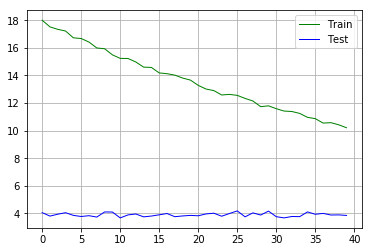

In [36]:
print ("Min values and epoch\ntrain: %s\ntest: %s" \
       %(np.array(train_epoch_loss_list).min(), np.array(test_epoch_loss_list).min()) )
train_loss, = plt.plot(train_epoch_loss_list, 'g-',linewidth = 1, label='Train')
test_loss, = plt.plot(test_epoch_loss_list, 'b-',linewidth = 1, label = "Test")
plt.legend(handles=[train_loss, test_loss])
plt.grid()
plt.show()

Save parameters to pickle file
====

In [ ]:
net_parametrs = net.state_dict()
with open('./result_nets.pkl','wb') as f:
    pickle.dump(net_parametrs,f)

Load parameters from pickle file
====

In [ ]:
with open('./result_nets.pkl','rb') as f:
    result_nets = pickle.load(f)
net.load_state_dict(result_nets)

Learn test data
====

In [ ]:
net.train(False)

batch_size = 1000
loss_acc = 0
Xperm = np.random.permutation(Xt.shape[0])
loss_fn = torch.nn.CrossEntropyLoss().cuda()
y_hat = []
for b in range(Xt.shape[0]//batch_size):
    batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
    x = Variable(torch.Tensor(Xt[batch_idxs].tolist()),volatile = True).cuda()
    y = Variable(torch.LongTensor(Yt[batch_idxs]),volatile = True).cuda()
    
    
    y_hat.append(net(x))
    loss = loss_fn(y_hat[b], y)
    loss_acc +=loss.data[0]

print (loss_acc / (Xt.shape[0]//batch_size))

Save result of test
====

In [ ]:
d = pandas.DataFrame()
d['id'] = range(len(Yt))
res = y_hat
if type(y_hat) == list:
    res = y_hat[0].data.cpu().numpy()
    for i in range(1, len(y_hat)):
        res = np.vstack((res, y_hat[i].cpu().data.numpy()))
        
for i in range(10):
    d['c%s' % i] = np.exp(res[:, i])

In [ ]:
d.to_csv('./ground.csv', index=False)

**Classes:**
======
1. airplane 
2. automobile
3. bird
4. cat
5. deer 
6. dog
7. frog
8. horse
9. ship
10. truck.

In [ ]:
class Hyperparams:
    def __init__(self):
        self.lr0 = 0.0001
        self.epoch = 0
        self.punch = 0.0003
        self.lr = 0.0001
        self.base = 0.5
    
    @property
    def rate(self):
        return self.epoch // 15
    
    def make_punch(self):
        self.lr = self.punch
        self.epoch = 0
        
    @property
    def updated_lr(self):
        return self.lr0 * ( self.base **  self.rate )